In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime
from obspy import read
from obspy import Stream
from obspy import read_events
from obspy import UTCDateTime
from obspy import Catalog
import os

from scipy.stats import gaussian_kde

In [2]:
def convert_to_utc(df, columns):
    """Convert specified columns in a DataFrame to UTCDateTime."""
    for col in columns:
        df[col] = df[col].apply(lambda x: UTCDateTime(x) if pd.notnull(x) else None)
    return df

In [3]:
stalist= ['AM05', 'AQU', 'ARRO', 'ARVD', 'ASSB', 'ATBU', 'ATCC', 'ATFO', 'ATLO', 'ATMI', 'ATSC', 'ATTE', 'ATVA', 'ATVO', 'CADA', 'CAMP', 'CESI', 'CESX', 'CIMA', 'CING', 'CSP1', 'EL6', 'FAGN', 'FDMO', 'FEMA', 'FIAM', 'FIU1', 'FOSV', 'FRON', 'GAG1', 'GIGS', 'GUMA', 'LNSS', 'MC2', 'MDAR', 'MGAB', 'MMO1', 'MMUR', 'MNTP', 'MOMA', 'MTL1', 'MURB', 'NRCA', 'OFFI', 'PIO1', 'PP3', 'RM33', 'SEF1', 'SMA1', 'SNTG', 'SRES', 'SSFR', 'SSM1', 'T1201', 'T1202', 'T1204', 'T1211', 'T1212', 'T1213', 'T1214', 'T1215', 'T1216', 'T1217', 'T1218', 'T1219', 'T1220', 'T1221', 'T1241', 'T1243', 'T1244', 'T1245', 'T1246', 'T1247', 'T1256', 'T1299', 'TERO', 'TRE1', 'TRTR', 'VCEL']

In [4]:
filename = "picks_BSI.csv"
event_id_main = '8863681'

if os.path.exists(filename):
    df_picks= pd.read_csv("./picks_BSI.csv")
    print(f"✅ File letto: {filename}")
else:
    print(f"⏩ Creo e salvo il file: {filename}")

    cat_final=read_events("./catalog_ingv.xml")
    all_events_data = []
    
    # Loop su tutti gli eventi
    for curreve in cat_final:
        event_id = curreve.resource_id.id.split('=')[-1]  # Prendi l'ID dell'evento
        ori = curreve.origins[0]
        arrivals = ori.arrivals
        picks = curreve.picks
    
        ingvpick = []
        
        # Filtra i pick validi
        for ar in arrivals:
            if ar.phase and ar.phase[0] in ['P', 'S']:  # Controlla che la fase sia P o S
                pi = next((p for p in picks if p.resource_id == ar.pick_id), None)
                if pi and pi.waveform_id.station_code in stalist:
                    ingvpick.append(pi)
    
        # Dizionario per organizzare i pick per stazione
        data_dict = {}
    
        for pick in ingvpick:
            station_code = pick.waveform_id.station_code
            pick_time = pick.time
            pick_error = pick.time_errors.get('uncertainty', np.nan)
            phase_hint = pick.phase_hint
    
            if phase_hint and phase_hint[0] == 'P':  
                if station_code not in data_dict:
                    data_dict[station_code] = {
                        'Event ID': event_id,  # Aggiunge l'ID dell'evento
                        'Station': station_code,
                        'P pick': pick_time, 'P time_err': pick_error,
                        'S pick': np.nan, 'S time_err': np.nan
                    }
                else:
                    data_dict[station_code]['P pick'] = pick_time
                    data_dict[station_code]['P time_err'] = pick_error  
    
            elif phase_hint and phase_hint[0] == 'S':  
                if station_code not in data_dict:
                    data_dict[station_code] = {
                        'Event ID': event_id,  # Aggiunge l'ID dell'evento
                        'Station': station_code,
                        'P pick': np.nan, 'P time_err': np.nan,
                        'S pick': pick_time, 'S time_err': pick_error
                    }
                else:
                    data_dict[station_code]['S pick'] = pick_time
                    data_dict[station_code]['S time_err'] = pick_error  
    
        # Converti il dizionario in una lista e aggiungila a tutti gli eventi
        all_events_data.extend(data_dict.values())
    
    # Creazione del DataFrame finale con tutti gli eventi
    df_picks = pd.DataFrame(all_events_data)
    df_picks.to_csv("picks_BSI.csv", index=False)  # Senza colonna indice
    
    # Visualizza il DataFrame
    print(df_picks)


✅ File letto: picks_BSI.csv


In [5]:
# Conta il numero di volte che P time_err è maggiore di 1.0
count_p_err = (df_picks['P time_err'] > 1.0).sum()

# Conta il numero di volte che S time_err è maggiore di 1.0
count_s_err = (df_picks['S time_err'] > 1.0).sum()

print(f"Numero di P time_err > 1.0: {count_p_err}")
print(f"Numero di S time_err > 1.0: {count_s_err}")


Numero di P time_err > 1.0: 33835
Numero di S time_err > 1.0: 14135


In [6]:
# Define the directory containing the CSV files
csv_directory = '/home/jovyan/shared/users/spina/Norcia/NLLoc/SNR_INSTANCE_005/'  # replace with your directory path

# Use glob to find all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_directory, '*.csv'))

# List to hold all the DataFrames
dataframes_list = []

# Iterate over each CSV file and read it into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    # if (df['P_terr'].min() >= -60) or (df['P_terr'].max() <= 60):
    #     print('prolema P')
    #     print(df)
    # if (df['S_terr'].min() >= -60) or (df['S_terr'].max() <= 60):
    #     print('prolema S')
    #     print(df)

    # print(df['P_terr'].min())
    # print(df['P_terr'].max())
    # print(df['S_terr'].min())
    # print(df['S_terr'].max())
    
    
    dataframes_list.append(df)

# # Combine all the DataFrames into a single DataFrame
combined_in_df = pd.concat(dataframes_list, ignore_index=True)
combined_in_df = convert_to_utc(combined_in_df, ['P pick', 'S pick', 'P pn', 'S pn'])
combined_in_df['Psnr'] = combined_in_df['Psnr']
combined_in_df['Ssnr'] = combined_in_df['Ssnr']

In [43]:
filtered_combined_in_df = combined_in_df.loc[(combined_in_df['Pproba'] >= 0.1) & (combined_in_df['Sproba'] >= 0.1)]
filtered_combined_in_df['Pproba'].min()

0.100008644

In [7]:
# Define the directory containing the CSV files
csv_directory_or = '/home/jovyan/shared/users/spina/Norcia/NLLoc/SNR/'  # replace with your directory path

# Use glob to find all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_directory_or, '*.csv'))

# List to hold all the DataFrames
dataframes_list = []

# Iterate over each CSV file and read it into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    # if (df['P_terr'].min() >= -60) or (df['P_terr'].max() <= 60):
    #     print('prolema P')
    #     print(df)
    # if (df['S_terr'].min() >= -60) or (df['S_terr'].max() <= 60):
    #     print('prolema S')
    #     print(df)

    # print(df['P_terr'].min())
    # print(df['P_terr'].max())
    # print(df['S_terr'].min())
    # print(df['S_terr'].max())
    
    
    dataframes_list.append(df)

# # Combine all the DataFrames into a single DataFrame
combined_or_df = pd.concat(dataframes_list, ignore_index=True)
combined_or_df = convert_to_utc(combined_or_df, ['P pick', 'S pick', 'P pn', 'S pn'])
combined_or_df['Psnr'] = combined_or_df['Psnr']
combined_or_df['Ssnr'] = combined_or_df['Ssnr']
# Filtra il DataFrame per le condizioni specificate
filtered_combined_or_df = combined_or_df.loc[(combined_or_df['Pproba'] >= 0.1) & (combined_or_df['Sproba'] >= 0.1)]


In [8]:
for col in ['P pick', 'S pick']:
    df_picks[col] = df_picks[col].apply(lambda x: x.datetime if isinstance(x, UTCDateTime) else x)
for col in ['P pick', 'S pick','P pn','S pn']:
    combined_in_df[col] = combined_in_df[col].apply(lambda x: x.datetime if isinstance(x, UTCDateTime) else x)
    combined_or_df[col] = combined_or_df[col].apply(lambda x: x.datetime if isinstance(x, UTCDateTime) else x)

# for col in ['P pick', 'S pick','P pn','S pn']:
    # Converti in datetime, se non lo è già

for col in ['P pick', 'S pick']:
    df_picks[col] = pd.to_datetime(df_picks[col])
    if df_picks[col].dt.tz is None:
        df_picks[col] = df_picks[col].dt.tz_localize('UTC')
    else:
        df_picks[col] = df_picks[col].dt.tz_convert('UTC')

for col in ['P pick', 'S pick','P pn','S pn']:
    combined_in_df[col] = pd.to_datetime(combined_in_df[col])
    combined_or_df[col] = pd.to_datetime(combined_or_df[col])
    
    # Se ha già un timezone, usa tz_convert; altrimenti, usa tz_localize

    if combined_in_df[col].dt.tz is None:
        combined_in_df[col] = combined_in_df[col].dt.tz_localize('UTC')
    else:
        combined_in_df[col] = combined_in_df[col].dt.tz_convert('UTC')

    if combined_or_df[col].dt.tz is None:
        combined_or_df[col] = combined_or_df[col].dt.tz_localize('UTC')
    else:
        combined_or_df[col] = combined_or_df[col].dt.tz_convert('UTC')

merged_in_df = pd.merge(df_picks, combined_in_df, on=['Station', 'P pick', 'S pick'], how='inner')
merged_or_df = pd.merge(df_picks, combined_or_df, on=['Station', 'P pick', 'S pick'], how='inner')


In [9]:
main_in_df=merged_in_df[merged_in_df['Event ID']==int(event_id_main)]
main_or_df=merged_or_df[merged_or_df['Event ID']==int(event_id_main)]

In [10]:
def plot_dual_scatter(df1, df2, modelname1, modelname2):
    """
    Crea una figura con due scatter plot affiancati (2 pannelli).
    Mostra (S pick - P pick) vs (S pn - P pn) per due DataFrame separati.
    
    Parametri:
    df1, df2 (pd.DataFrame): DataFrame contenenti le colonne necessarie.
    modelname1, modelname2 (str): Nomi dei modelli per i titoli e le etichette.
    """

    def preprocess_data(df):
        """Filtra e calcola le differenze temporali."""
        df_filtered = df.dropna(subset=['P_terr', 'S_terr', 'P pick', 'S pick', 'P pn', 'S pn'])
        df_filtered = df_filtered[(df_filtered['P_terr'].abs() < 2) & (df_filtered['S_terr'].abs() < 2)]
        x_values = (df_filtered['S pick'] - df_filtered['P pick']).dt.total_seconds()
        y_values = (df_filtered['S pn'] - df_filtered['P pn']).dt.total_seconds()
        return x_values, y_values

    # Preprocessamento dei due dataframe
    x1, y1 = preprocess_data(df1)
    x2, y2 = preprocess_data(df2)

    # Creazione della figura con due subplot affiancati
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    for ax, x, y, modelname in zip(axes, [x1, x2], [y1, y2], [modelname1, modelname2]):
        # Scatter plot
        ax.scatter(x, y, alpha=0.6, edgecolors='k', label="Data")

        # Aggiungere la retta y = x
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--', linewidth=2, label='$y = x$')

        # Etichette e titolo
        ax.set_xlabel("$t_S - t_P$ (s) BSI-R")
        ax.set_ylabel("$t_S - t_P$ (s) " + modelname)
        # ax.set_title(f"Scatter plot: {modelname}")
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend()

    # Miglior layout
    plt.tight_layout()

    # Salvare la figura
    filename = f"./FIGURE/ts-tp_{modelname1}_{modelname2}.png"
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Figura salvata come {filename}")


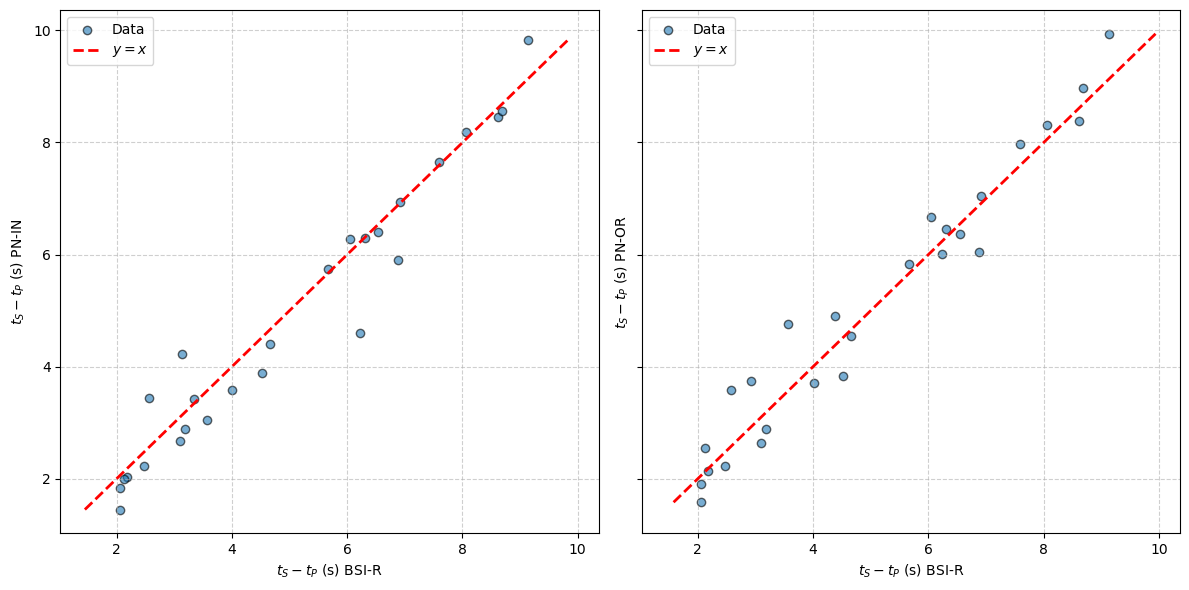

Figura salvata come ./FIGURE/ts-tp_PN-IN_PN-OR.png


In [11]:
plot_dual_scatter(main_in_df, main_or_df, 'PN-IN', 'PN-OR')

/tmp/ipykernel_8739/2995929525.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_counts = merged_in_df.groupby(['P Quality', 'Pproba_binned']).size().reset_index(name='count')
/tmp/ipykernel_8739/2995929525.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s_counts = merged_in_df.groupby(['S Quality', 'Sproba_binned']).size().reset_index(name='count')


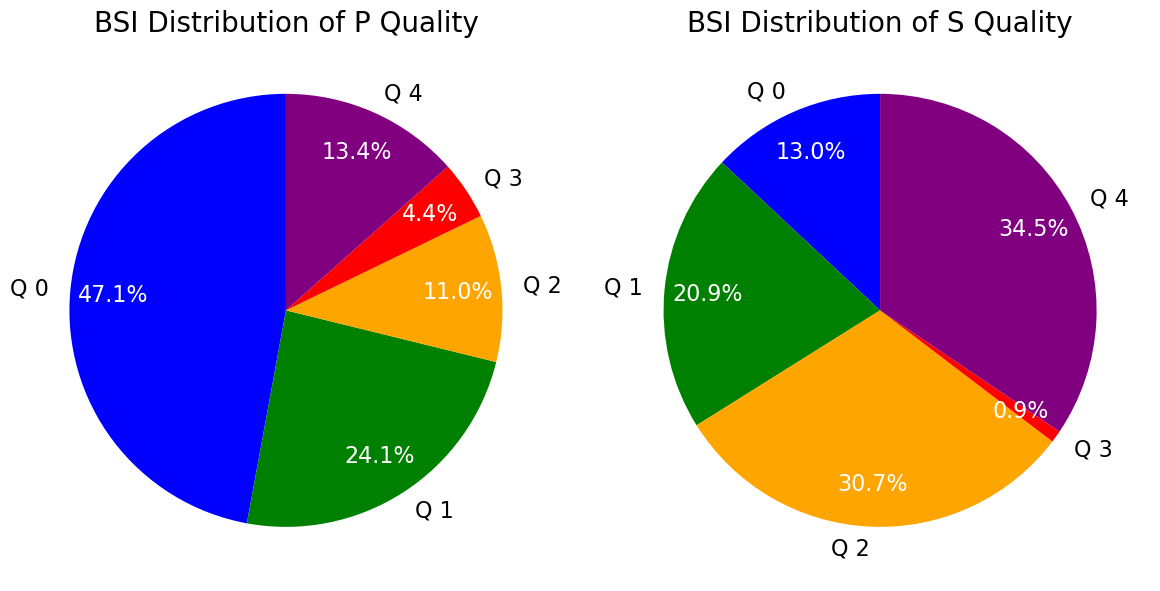

In [13]:

def classify_quality(time_err):
    if 0 < time_err <= 0.1:
        return 0
    elif 0.1 < time_err <= 0.3:
        return 1
    elif 0.3 < time_err <= 0.6:
        return 2
    elif 0.6 < time_err <= 1.0:
        return 3
    else:
        return 4

# Applica la funzione per ottenere il Quality
merged_in_df['P Quality'] = merged_in_df['P time_err'].apply(classify_quality)
merged_in_df['S Quality'] = merged_in_df['S time_err'].apply(classify_quality)

# Definisci l'intervallo per Pproba e Sproba
intervals = np.arange(0, 1.05, 0.05)

# Usa pd.cut() per suddividere Pproba e Sproba in intervalli di 0.05
merged_in_df['Pproba_binned'] = pd.cut(merged_in_df['Pproba'], bins=intervals, right=False)
merged_in_df['Sproba_binned'] = pd.cut(merged_in_df['Sproba'], bins=intervals, right=False)

# Conta le occorrenze per ogni combinazione unica di P time_err, Pproba_binned
p_counts = merged_in_df.groupby(['P Quality', 'Pproba_binned']).size().reset_index(name='count')

# Conta le occorrenze per ogni combinazione unica di S time_err, Sproba_binned
s_counts = merged_in_df.groupby(['S Quality', 'Sproba_binned']).size().reset_index(name='count')


# Conta il numero di occorrenze per ogni classe di Quality
p_quality_counts = merged_in_df['P Quality'].value_counts().sort_index()
s_quality_counts = merged_in_df['S Quality'].value_counts().sort_index()

# Definisci colori e etichette
colors = ['blue', 'green', 'orange', 'red', 'purple']
labels = [f'Q {i}' for i in range(len(p_quality_counts))]

# Crea la figura con due pie-chart affiancati
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams['font.size'] = 16
_, _, autotexts = axes[0].pie(p_quality_counts,labels = labels, autopct='%1.1f%%',pctdistance=0.8,startangle=90,colors=colors)
for autotext in autotexts:
    autotext.set_color('white')
_, _, autotexts = axes[1].pie(s_quality_counts,labels = labels, autopct='%1.1f%%',pctdistance=0.8,startangle=90,colors=colors)
for autotext in autotexts:
    autotext.set_color('white')

# Pie-chart per P Quality
# axes[0].pie(p_quality_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'k'})
axes[0].set_title('BSI Distribution of P Quality',fontsize=20)

# Pie-chart per S Quality
# axes[1].pie(s_quality_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'k'})
axes[1].set_title('BSI Distribution of S Quality',fontsize=20)

# Mostra i grafici
plt.tight_layout()
plt.savefig('./FIGURE/quality_perc.png',dpi=150)
plt.show()


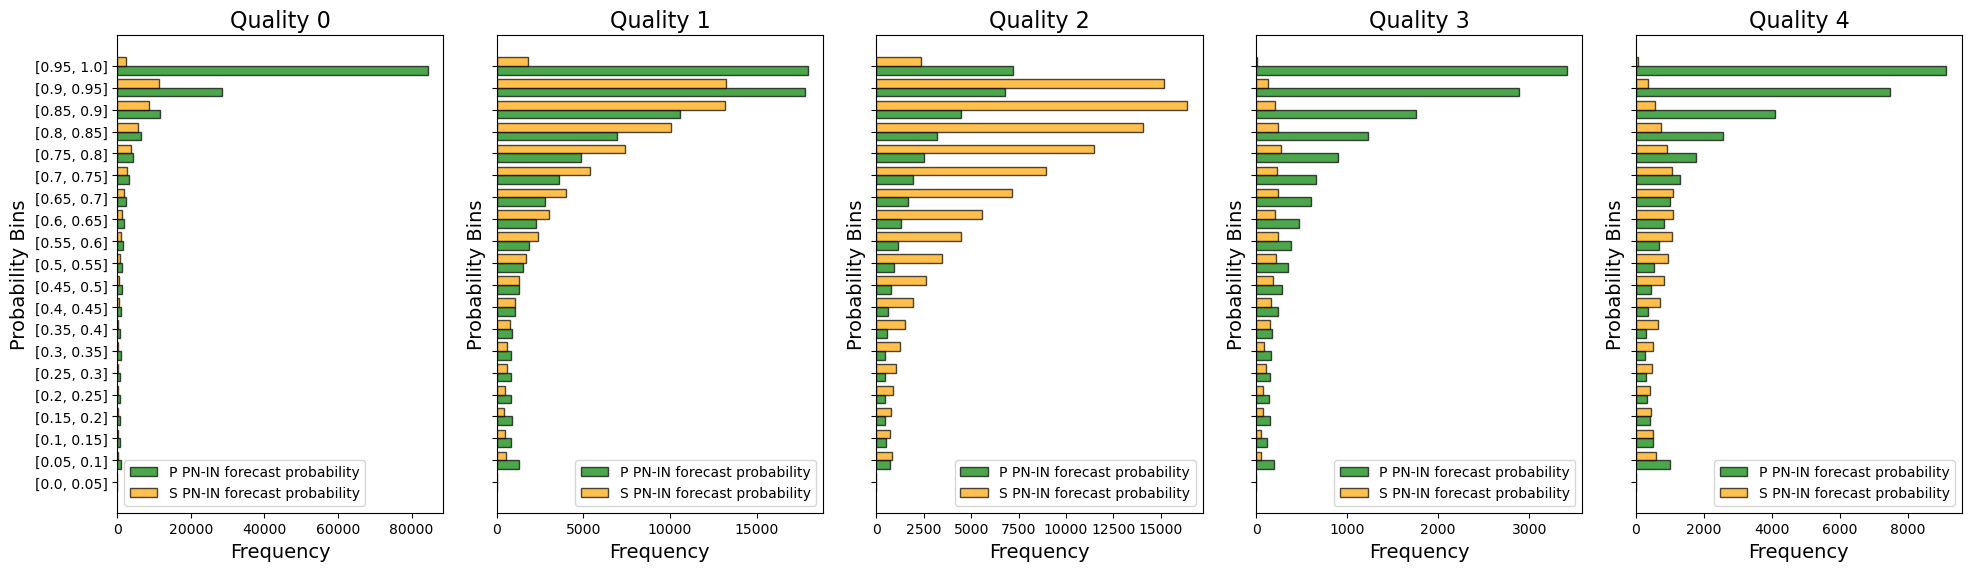

In [17]:

# # Definisci gli intervalli per il binning di Pproba e Sproba
# intervals = np.arange(0, 1.05, 0.05)

# Applica il binning
merged_in_df['Pproba_binned'] = pd.cut(merged_in_df['Pproba'], bins=intervals, right=False)
merged_in_df['Sproba_binned'] = pd.cut(merged_in_df['Sproba'], bins=intervals, right=False)


# Aggiungi la colonna Quality
merged_in_df['P Quality'] = merged_in_df['P time_err'].apply(classify_quality)
merged_in_df['S Quality'] = merged_in_df['S time_err'].apply(classify_quality)

# Creiamo il plot con 5 pannelli (1x5)
fig, axes = plt.subplots(1, 5, figsize=(20, 6),  sharey=True)
axes = axes.flatten()  # Rende più facile accedere agli assi
mpl.rcParams.update({
    "axes.labelsize": 12,   # dimensione etichette assi
    "xtick.labelsize": 10,   # dimensione tick asse x
    "ytick.labelsize": 10,   # dimensione tick asse y
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "axes.titlesize": 13
})


# Colori per ogni classe di Quality
colors = ['blue', 'green', 'orange', 'red', 'purple']
titles = ['Quality 0', 'Quality 1', 'Quality 2', 'Quality 3', 'Quality 4']

# Larghezza della barra e offset per separare le barre
bar_height = 0.4  

# Loop sulle classi di Quality (da 0 a 4) per creare i pannelli
for quality in range(5):
    ax = axes[quality]
    
    # Filtra i dati per la classe di Quality attuale
    p_counts = merged_in_df[merged_in_df['P Quality'] == quality].groupby(['P time_err', 'Pproba_binned'], observed=False).size().reset_index(name='count')
    s_counts = merged_in_df[merged_in_df['S Quality'] == quality].groupby(['S time_err', 'Sproba_binned'], observed=False).size().reset_index(name='count')

    # Convertire le categorie in etichette testuali per l'asse Y
    p_counts['Pproba_label'] = p_counts['Pproba_binned'].astype(str)
    s_counts['Sproba_label'] = s_counts['Sproba_binned'].astype(str)

    # Rimuovere eventuali valori NaN
    p_counts = p_counts.dropna(subset=['Pproba_label'])
    s_counts = s_counts.dropna(subset=['Sproba_label'])

    # Creare una lista unica di intervalli per l'asse Y
    y_labels = sorted(set(p_counts['Pproba_label']).union(set(s_counts['Sproba_label'])))
    y_pos = np.arange(len(y_labels))

    # Mappare le etichette agli indici numerici
    p_counts['y_index'] = p_counts['Pproba_label'].apply(lambda x: y_labels.index(x))
    s_counts['y_index'] = s_counts['Sproba_label'].apply(lambda x: y_labels.index(x))

    # Disegna le barre orizzontali
    ax.barh(p_counts['y_index'] - bar_height/2, p_counts['count'], height=bar_height, color='green', alpha=0.7, edgecolor='k', label='P PN-IN forecast probability')
    ax.barh(s_counts['y_index'] + bar_height/2, s_counts['count'], height=bar_height, color='orange', alpha=0.7, edgecolor='k', label='S PN-IN forecast probability')

    # Imposta titolo e etichette
    ax.set_title(titles[quality], fontsize=16)
    ax.set_xlabel('Frequency', fontsize=14)
    ax.set_ylabel('Probability Bins', fontsize=14)

    # Imposta l'asse Y con le etichette testuali
    ax.set_yticks(y_pos)
    # ax.set_yticklabels(y_labels, fontsize=8, rotation=0)
    ax.set_yticklabels([s.replace(")","]") for s in y_labels])
    ax.legend()  # Aggiungi legenda

# Layout pulito e mostra il grafico
plt.tight_layout()
plt.savefig("./FIGURE/quality_proba_PN_IN.png")
plt.show()


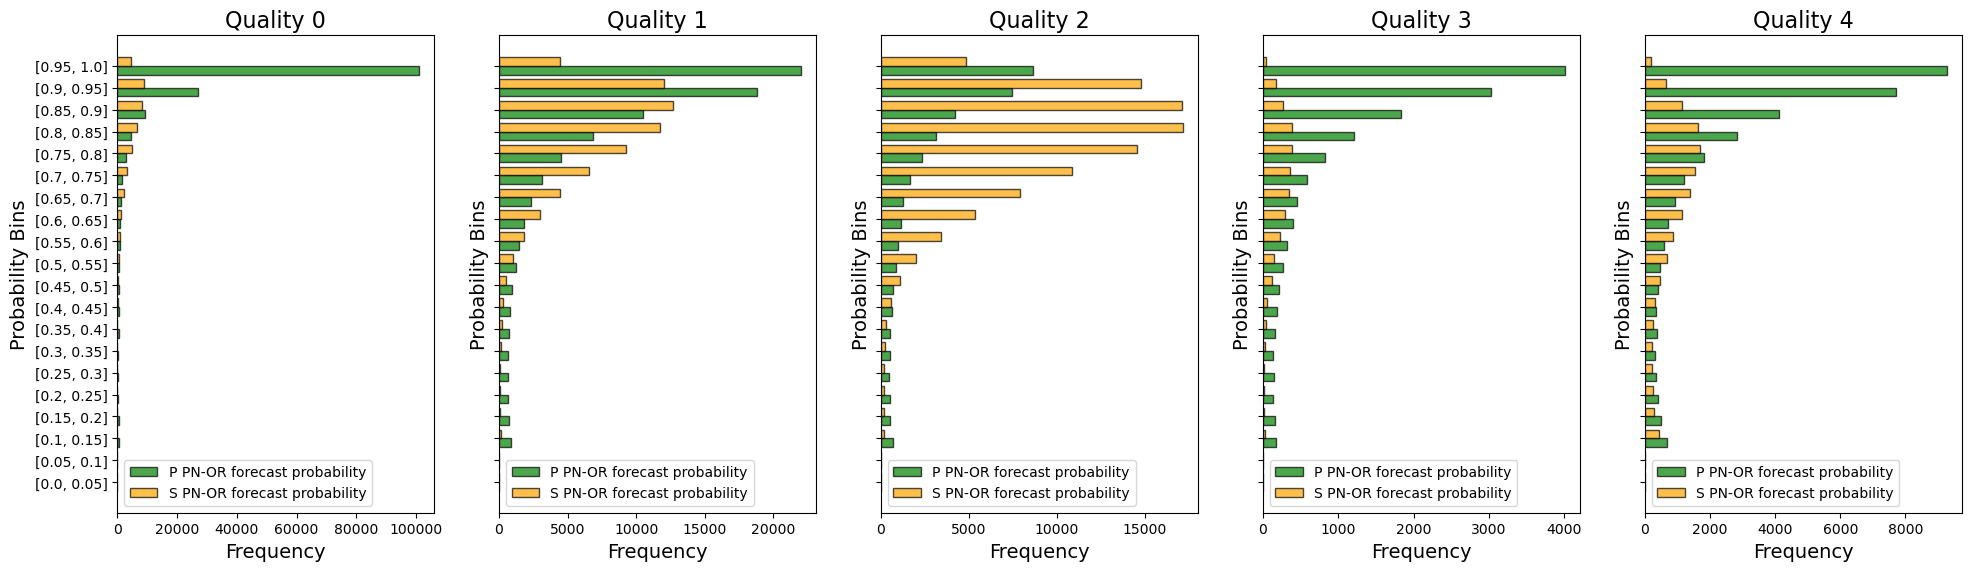

In [15]:
# Definisci gli intervalli per il binning di Pproba e Sproba
intervals = np.arange(0, 1.05, 0.05)

# Applica il binning
merged_or_df['Pproba_binned'] = pd.cut(merged_or_df['Pproba'], bins=intervals, right=False)
merged_or_df['Sproba_binned'] = pd.cut(merged_or_df['Sproba'], bins=intervals, right=False)


# Aggiungi la colonna Quality
merged_or_df['P Quality'] = merged_or_df['P time_err'].apply(classify_quality)
merged_or_df['S Quality'] = merged_or_df['S time_err'].apply(classify_quality)

# Creiamo il plot con 5 pannelli (1x5)
fig, axes = plt.subplots(1, 5, figsize=(20, 6),  sharey=True)
axes = axes.flatten()  # Rende più facile accedere agli assi

# Colori per ogni classe di Quality
colors = ['blue', 'green', 'orange', 'red', 'purple']
titles = ['Quality 0', 'Quality 1', 'Quality 2', 'Quality 3', 'Quality 4']

# Larghezza della barra e offset per separare le barre
bar_height = 0.4  

# Loop sulle classi di Quality (da 0 a 4) per creare i pannelli
for quality in range(5):
    ax = axes[quality]
    
    # Filtra i dati per la classe di Quality attuale
    p_counts = merged_or_df[merged_or_df['P Quality'] == quality].groupby(['P time_err', 'Pproba_binned'], observed=False).size().reset_index(name='count')
    s_counts = merged_or_df[merged_or_df['S Quality'] == quality].groupby(['S time_err', 'Sproba_binned'], observed=False).size().reset_index(name='count')

    # Convertire le categorie in etichette testuali per l'asse Y
    p_counts['Pproba_label'] = p_counts['Pproba_binned'].astype(str)
    s_counts['Sproba_label'] = s_counts['Sproba_binned'].astype(str)

    # Rimuovere eventuali valori NaN
    p_counts = p_counts.dropna(subset=['Pproba_label'])
    s_counts = s_counts.dropna(subset=['Sproba_label'])

    # Creare una lista unica di intervalli per l'asse Y
    y_labels = sorted(set(p_counts['Pproba_label']).union(set(s_counts['Sproba_label'])))
    y_pos = np.arange(len(y_labels))

    # Mappare le etichette agli indici numerici
    p_counts['y_index'] = p_counts['Pproba_label'].apply(lambda x: y_labels.index(x))
    s_counts['y_index'] = s_counts['Sproba_label'].apply(lambda x: y_labels.index(x))

    # Disegna le barre orizzontali
    ax.barh(p_counts['y_index'] - bar_height/2, p_counts['count'], height=bar_height, color='green', alpha=0.7, edgecolor='k', label='P PN-OR forecast probability')
    ax.barh(s_counts['y_index'] + bar_height/2, s_counts['count'], height=bar_height, color='orange', alpha=0.7, edgecolor='k', label='S PN-OR forecast probability')

    # Imposta titolo e etichette
    ax.set_title(titles[quality], fontsize=16)
    ax.set_xlabel('Frequency', fontsize=14)
    ax.set_ylabel('Probability Bins', fontsize=14)

    # Imposta l'asse Y con le etichette testuali
    ax.set_yticks(y_pos)
    # ax.set_yticklabels(y_labels, fontsize=8, rotation=0)
    ax.set_yticklabels([s.replace(")","]") for s in y_labels])
    ax.legend()  # Aggiungi legenda

# Layout pulito e mostra il grafico
plt.tight_layout()
plt.savefig("./FIGURE/quality_proba_PN_OR.png")
plt.show()


In [16]:
from obspy.clients.filesystem.sds import Client
sdsmug = Client("/home/jovyan/data/sds/")

In [115]:
filter = combined_in_df[(combined_in_df['P pick'].notna()) & (combined_in_df['P pn'].notna()) & (combined_in_df['Psnr']=='NTA')]

In [116]:
filter = merged_in_df[(merged_in_df['P Quality']==4) & (merged_in_df['Pproba']>=0.9)]

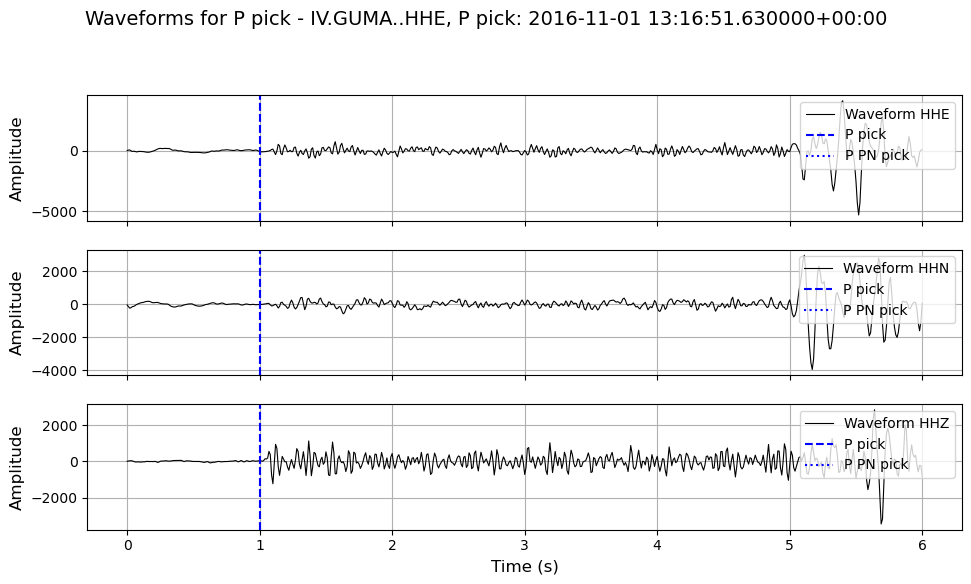

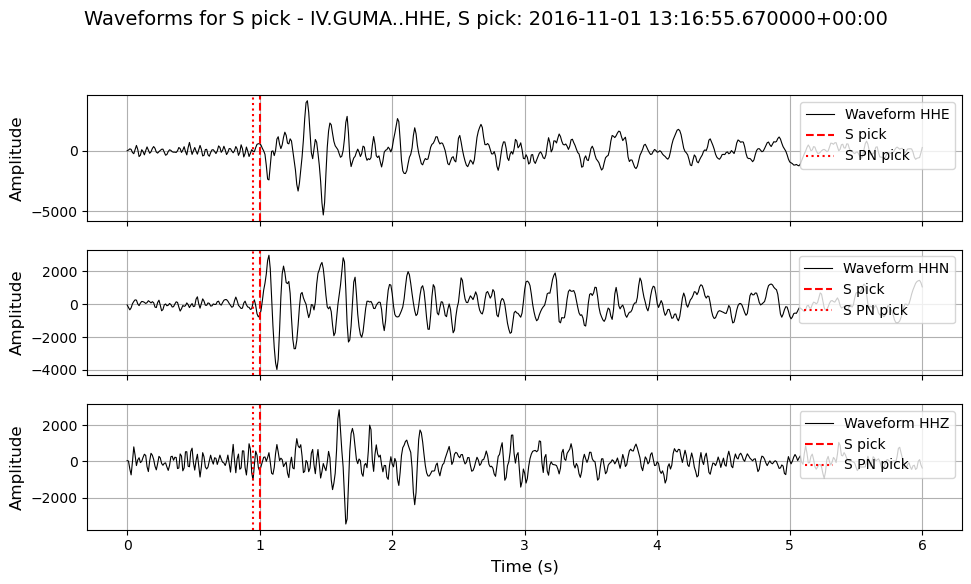

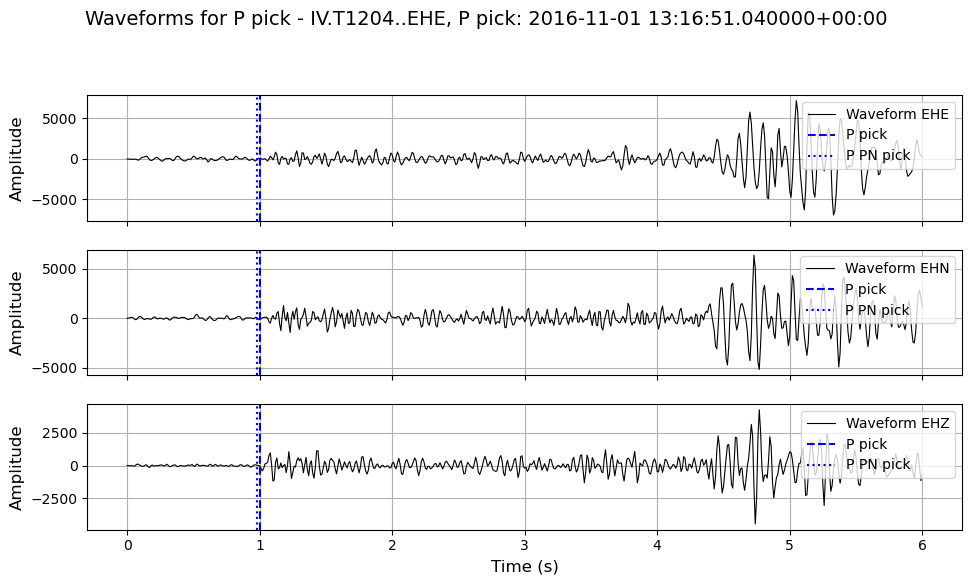

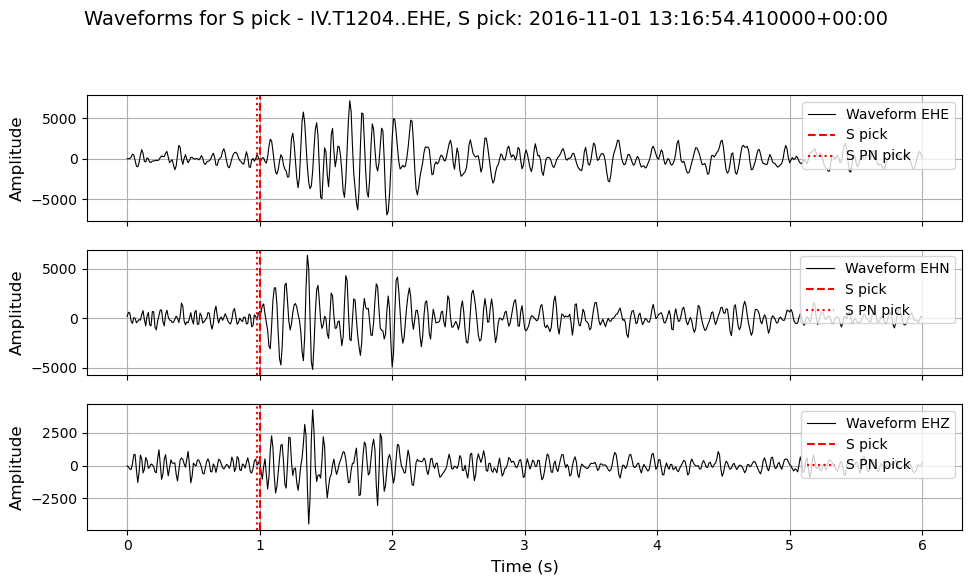

In [120]:
filter = merged_in_df[(merged_in_df['P_terr']<=0.1) & (merged_in_df['S_terr']<=0.1)]

stations_of_interest = filter['Station'].unique()

for i, row in filter[2:4].iterrows():
    waveform_id = row['id']  # Formato: network.station.location.channel
    net, sta, loc, chan = waveform_id.split('.')
    
    if sta in stations_of_interest:
        try:
            # Controllo su 'P pick'
            if pd.notna(row['P pick']):  
                p_time = UTCDateTime(row['P pick'])
                begin = p_time - 1
                end = begin + 6
                
                st = Stream()
                st = sdsmug.get_waveforms(net, sta, loc, chan[0:2] + '*', begin, end)
                
                if len(st) == 0:
                    print(f"Riga {i}: Nessuna forma d'onda trovata per P pick - {waveform_id}")
                    continue
                
                st.merge(method=0, fill_value='interpolate')
                st.detrend('linear')
                st.detrend('demean')
                st.filter('bandpass', freqmin=1, freqmax=30)
                
                fig, axs = plt.subplots(len(st), 1, figsize=(10, 2 * len(st)), sharex=True)
                if len(st) == 1:
                    axs = [axs]
                
                for idx, tr in enumerate(st):
                    if tr.stats.npts is None or tr.stats.delta is None:
                        print(f"Riga {i}: Problema con i dati della traccia - {waveform_id}")
                        continue
                    
                    time_axis = np.arange(tr.stats.npts) * tr.stats.delta
                    start_time = tr.stats.starttime
                    p_pick_offset = UTCDateTime(row['P pick']) - start_time
                    p_pn_pick_offset = UTCDateTime(row['P pn']) - start_time
                    
                    axs[idx].plot(time_axis, tr.data, color='black', lw=0.8, label=f'Waveform {tr.stats.channel}')
                    axs[idx].axvline(p_pick_offset, color='blue', linestyle='--', label='P pick')
                    axs[idx].axvline(p_pn_pick_offset, color='blue', linestyle=':', label='P PN pick')
                    axs[idx].set_ylabel("Amplitude")
                    axs[idx].legend(loc='upper right')
                    axs[idx].grid(True)
                
                plt.suptitle(f"Waveforms for P pick - {waveform_id}, P pick: {row['P pick']}", fontsize=14)
                axs[-1].set_xlabel("Time (s)")
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                nome = f"{net}_{sta}_{row['P pick']}.png"
                plt.savefig('./fig_missing_picks/Q1_' + nome)
            
            # Controllo su 'S pick'
            if pd.notna(row['S pick']):  
                s_time = UTCDateTime(row['S pick'])
                begin = s_time - 1
                end = begin + 6
                
                st = Stream()
                st = sdsmug.get_waveforms(net, sta, loc, chan[0:2] + '*', begin, end)
                
                if len(st) == 0:
                    print(f"Riga {i}: Nessuna forma d'onda trovata per S pick - {waveform_id}")
                    continue
                
                st.merge(method=0, fill_value='interpolate')
                st.detrend('linear')
                st.detrend('demean')
                st.filter('bandpass', freqmin=1, freqmax=30)
                
                fig, axs = plt.subplots(len(st), 1, figsize=(10, 2 * len(st)), sharex=True)
                if len(st) == 1:
                    axs = [axs]
                
                for idx, tr in enumerate(st):
                    if tr.stats.npts is None or tr.stats.delta is None:
                        print(f"Riga {i}: Problema con i dati della traccia - {waveform_id}")
                        continue
                    
                    time_axis = np.arange(tr.stats.npts) * tr.stats.delta
                    start_time = tr.stats.starttime
                    s_pick_offset = UTCDateTime(row['S pick']) - start_time
                    s_pn_pick_offset = UTCDateTime(row['S pn']) - start_time
                    
                    axs[idx].plot(time_axis, tr.data, color='black', lw=0.8, label=f'Waveform {tr.stats.channel}')
                    axs[idx].axvline(s_pick_offset, color='red', linestyle='--', label='S pick')
                    axs[idx].axvline(s_pn_pick_offset, color='red', linestyle=':', label='S PN pick')
                    axs[idx].set_ylabel("Amplitude")
                    axs[idx].legend(loc='upper right')
                    axs[idx].grid(True)
                
                plt.suptitle(f"Waveforms for S pick - {waveform_id}, S pick: {row['S pick']}", fontsize=14)
                axs[-1].set_xlabel("Time (s)")
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                nome = f"{net}_{sta}_{row['S pick']}.png"
                plt.savefig('./fig_missing_picks/Q1_' + nome)
                plt.show()
        
        except Exception as e:
            print(f"Errore nella riga {i}: {e}")


In [33]:
merged_or_df.loc[merged_or_df['S_terr']>60]

,Event ID,Station,P pick,P time_err,S pick,S time_err,id,P pn,S pn,Pproba,...,Psnr,Pfreq,Ssnr,Sfreq,P_terr,S_terr,Pproba_binned,Sproba_binned,P Quality,S Quality
6088,9253951,ARVD,2016-11-04 05:13:02.730000+00:00,0.3,2016-11-04 05:16:14+00:00,0.6,IV.ARVD..HHE,2016-11-04 05:13:02.900000+00:00,2016-11-04 05:13:14.180000+00:00,0.877959,...,4.022177,2.0,5.280681,0.05,-0.17,179.82,"[0.85, 0.9)","[0.8, 0.85)",1,2
6089,9253951,FAGN,2016-11-04 05:13:01.300000+00:00,0.6,2016-11-04 05:16:12.200000+00:00,1.0,IV.FAGN..HHE,2016-11-04 05:13:01.660000+00:00,2016-11-04 05:13:12.290000+00:00,0.447445,...,4.177757,0.05,1.708915,0.05,-0.36,179.91,"[0.4, 0.45)","[0.35, 0.4)",2,3
6090,9253951,MURB,2016-11-04 05:13:01.640000+00:00,0.3,2016-11-04 05:16:12.800000+00:00,1.0,IV.MURB..HHE,2016-11-04 05:13:01.990000+00:00,2016-11-04 05:13:12.880000+00:00,0.780457,...,11.211457,2.0,2.414878,0.05,-0.35,179.92,"[0.75, 0.8)","[0.85, 0.9)",1,3
6091,9253951,FOSV,2016-11-04 05:13:00.120000+00:00,0.3,2016-11-04 05:16:09.200000+00:00,0.3,IV.FOSV..EHE,2016-11-04 05:13:00.140000+00:00,2016-11-04 05:13:09.250000+00:00,0.803011,...,10.132638,2.0,2.552302,0.05,-0.02,179.95,"[0.8, 0.85)","[0.8, 0.85)",1,1
8936,9256941,CESI,2016-11-04 06:13:17.950000+00:00,0.1,2016-11-04 06:21:22.400000+00:00,0.3,IV.CESI..HHE,2016-11-04 06:13:18.030000+00:00,2016-11-04 06:13:22.700000+00:00,0.970791,...,32.991558,2.0,-7.394237,0.05,-0.08,479.70,"[0.95, 1.0)","[0.6, 0.65)",0,1
8937,9256941,T1221,2016-11-04 06:12:00.830000+00:00,0.1,2016-11-04 06:14:04.800000+00:00,0.1,IV.T1221..EHE,2016-11-04 06:12:00.850000+00:00,2016-11-04 06:12:04.850000+00:00,0.982900,...,19.855153,2.0,-0.416177,0.05,-0.02,119.95,"[0.95, 1.0)","[0.85, 0.9)",0,0
26775,9145491,CSP1,2016-11-02 17:47:39.300000+00:00,0.1,2016-11-02 17:53:42.900000+00:00,0.3,IV.CSP1..EHE,2016-11-02 17:47:39.350000+00:00,2016-11-02 17:47:43.150000+00:00,0.947396,...,18.550102,2.0,NTA,NTA,-0.05,359.75,"[0.9, 0.95)","[0.5, 0.55)",0,1
51015,9217281,EL6,2016-11-03 17:33:01.070000+00:00,0.3,2016-11-03 17:36:09.100000+00:00,0.3,IV.EL6..EHE,2016-11-03 17:33:01.130000+00:00,2016-11-03 17:33:09.310000+00:00,0.921503,...,14.489654,1.0,2.64435,2.0,-0.06,179.79,"[0.9, 0.95)","[0.6, 0.65)",1,1
51016,9217281,SNTG,2016-11-03 17:33:00.020000+00:00,0.6,2016-11-03 17:36:06.700000+00:00,0.6,IV.SNTG..HHE,2016-11-03 17:32:59.930000+00:00,2016-11-03 17:33:06.800000+00:00,0.861982,...,11.286369,2.0,3.570484,0.05,0.09,179.90,"[0.85, 0.9)","[0.7, 0.75)",2,2
60276,9242481,FRON,2016-11-04 01:37:03.990000+00:00,0.1,2016-11-04 01:42:15.500000+00:00,0.6,IV.FRON..EHE,2016-11-04 01:37:04.020000+00:00,2016-11-04 01:37:35.540000+00:00,0.958733,...,22.821553,2.0,-0.617856,0.05,-0.03,279.96,"[0.95, 1.0)","[0.25, 0.3)",0,2


In [31]:
merged_or_df

,Event ID,Station,P pick,P time_err,S pick,S time_err,id,P pn,S pn,Pproba,...,Psnr,Pfreq,Ssnr,Sfreq,P_terr,S_terr,Pproba_binned,Sproba_binned,P Quality,S Quality
0,9051711,GIGS,2016-11-01 13:16:55.910000+00:00,0.3,2016-11-01 13:17:03.450000+00:00,0.3,IV.GIGS..HH1,2016-11-01 13:16:55.910000+00:00,2016-11-01 13:17:03.380000+00:00,0.964661,...,7.526365,2.0,13.747779,2.0,-0.00,0.07,"[0.95, 1.0)","[0.65, 0.7)",1,1
1,9051711,ATVO,2016-11-01 13:17:01.350000+00:00,0.6,NaT,NaN,IV.ATVO..HHE,2016-11-01 13:17:01.710000+00:00,NaT,0.216895,...,2.663471,2.0,NaN,NaN,-0.36,NaN,"[0.2, 0.25)",NaN,2,4
2,9051711,TERO,2016-11-01 13:16:53.750000+00:00,0.1,2016-11-01 13:16:59.660000+00:00,0.1,IV.TERO..HHE,2016-11-01 13:16:53.690000+00:00,2016-11-01 13:16:59.590000+00:00,0.944798,...,16.39476,2.0,12.991585,0.5,0.06,0.07,"[0.9, 0.95)","[0.9, 0.95)",0,0
3,9051711,T1246,2016-11-01 13:16:53.360000+00:00,0.1,2016-11-01 13:16:58.680000+00:00,0.1,IV.T1246..HHE,2016-11-01 13:16:53.330000+00:00,2016-11-01 13:16:58.700000+00:00,0.967626,...,12.772003,2.0,13.726917,2.0,0.03,-0.02,"[0.95, 1.0)","[0.85, 0.9)",0,0
4,9051711,ATCC,2016-11-01 13:16:57.140000+00:00,0.1,NaT,NaN,IV.ATCC..EHE,2016-11-01 13:16:57.150000+00:00,NaT,0.962818,...,7.199988,1.0,NaN,NaN,-0.01,NaN,"[0.95, 1.0)",NaN,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328172,8921931,ATCC,2016-10-30 23:16:27.740000+00:00,0.3,NaT,NaN,IV.ATCC..EHE,2016-10-30 23:16:27.750000+00:00,NaT,0.898462,...,1.603438,2.0,NaN,NaN,-0.01,NaN,"[0.85, 0.9)",NaN,1,4
328173,8921931,T1256,2016-10-30 23:16:23.750000+00:00,0.1,2016-10-30 23:16:26.810000+00:00,0.6,IV.T1256..HHE,2016-10-30 23:16:23.760000+00:00,2016-10-30 23:16:26.790000+00:00,0.973389,...,4.574463,2.0,11.698263,2.0,-0.01,0.02,"[0.95, 1.0)","[0.8, 0.85)",0,2
328174,8921931,T1245,2016-10-30 23:16:23.370000+00:00,0.3,2016-10-30 23:16:25.960000+00:00,0.6,IV.T1245..HHE,2016-10-30 23:16:23.720000+00:00,2016-10-30 23:16:25.990000+00:00,0.576318,...,-0.212527,0.5,12.887046,2.0,-0.35,-0.03,"[0.55, 0.6)","[0.85, 0.9)",1,2
328175,8921931,FEMA,2016-10-30 23:16:22.150000+00:00,0.1,2016-10-30 23:16:23.840000+00:00,0.6,IV.FEMA..HNE,2016-10-30 23:16:22.170000+00:00,2016-10-30 23:16:23.880000+00:00,0.972136,...,10.013749,2.0,7.34562,2.0,-0.02,-0.04,"[0.95, 1.0)","[0.85, 0.9)",0,2


In [32]:
count_not_nan = merged_or_df['S_terr'].notna().sum()
print("Righe non NaN in S_terr:", count_not_nan)


Righe non NaN in S_terr: 228050


In [34]:
50/228050*100

0.021925016443762334

In [57]:
def percent(df):
    df['P_terr'] = pd.to_numeric(df['P_terr'], errors='coerce')
    df['Psnr']  = pd.to_numeric(df['Psnr'], errors='coerce')
    mask = (
        df['P_terr'].notna() &
        df['Psnr'].notna() &
        (df['P_terr'].abs() > 2) &
        (df['Psnr'] < 3)
    )
    count = mask.sum()
    print("Numero di righe con |P_terr| > 2 e Psnr < 3:", count)
    
    mask_abs_lt2 = df['P_terr'].notna() & (df['P_terr'].abs() <= 2)
    count_abs_lt2 = mask_abs_lt2.sum()
    print("Numero di righe con |P_terr| < 2:", count_abs_lt2)
    
    P_perc=count/count_abs_lt2*100
    print("percentage P ",P_perc)

    df['S_terr'] = pd.to_numeric(df['S_terr'], errors='coerce')
    df['Ssnr']  = pd.to_numeric(df['Ssnr'], errors='coerce')
    mask = (
        df['S_terr'].notna() &
        df['Ssnr'].notna() &
        (df['S_terr'].abs() > 2) &
        (df['Ssnr'] < 3)
    )
    count = mask.sum()
    print("Numero di righe con |S_terr| > 2 e Ssnr < 3:", count)
    
    mask_abs_lt2 = df['S_terr'].notna() & (df['S_terr'].abs() <= 2)
    count_abs_lt2 = mask_abs_lt2.sum()
    print("Numero di righe con |S_terr| < 2:", count_abs_lt2)
    
    S_perc=count/count_abs_lt2*100
    print("percentage S ",S_perc)

In [58]:
percent(merged_in_df)

Numero di righe con |P_terr| > 2 e Psnr < 3: 3328
Numero di righe con |P_terr| < 2: 310172
percentage P  1.0729530711992057
Numero di righe con |S_terr| > 2 e Ssnr < 3: 1651
Numero di righe con |S_terr| < 2: 220776
percentage S  0.7478167916802552


In [59]:
percent(merged_or_df)

Numero di righe con |P_terr| > 2 e Psnr < 3: 3811
Numero di righe con |P_terr| < 2: 308913
percentage P  1.2336806803209965
Numero di righe con |S_terr| > 2 e Ssnr < 3: 1523
Numero di righe con |S_terr| < 2: 221892
percentage S  0.6863699457393687
